identification of Dopimanergic Neurons in Substantia Nigra using ASAP CRN scnRNA cohort data.


In [2]:
#set up conda environment 
# in a terminal
# conda env create -f environment.yml
# conda init 
## restart terminal
# conda activate scvi-cells
# python -m ipykernel install --user --name=scvi-cells --display-name "Python (scvi-cells)"

In [1]:
import scvi, pandas as pd, numpy as np, scanpy as sc,  seaborn as sns, matplotlib.pyplot as plt
import sys, subprocess, importlib, warnings, math, os
from pathlib import Path

KeyboardInterrupt: 

## 1. Workspace Setup

### 1.1 Set dataset paths
In this example, we are working with the **PMDBS single‑cell RNA‑seq cohort** dataset:

- **Workflow** → `pmdbs_sc_rnaseq`  
- **Team** → `cohort`  
- **Source** → `pmdbs`  
- **Type** → `sc-rnaseq`  

These components are combined to construct the bucket and dataset names.  
We then set the path to the **cohort analysis outputs** and preview the available files.


In [ ]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

print("\nContents of workspace root:")
for p in WS_ROOT.glob("*"):
    print(" -", p.name, "/" if p.is_dir() else "")

In [ ]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

bucket_name  = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"

dataset_path = DATASETS_PATH / bucket_name / workflow
print("Dataset Path:", dataset_path)

# Build the folder path to the cohort analysis directory
cohort_analysis_path = dataset_path / "cohort_analysis"

# Preview the directory contents
print("Contents of cohort_analysis:")
!ls {cohort_analysis_path}

In [ ]:
# Define a local path for workshop files
local_data_path = WS_FILES / "case_study_01"

# map my cells directories
mapmycells_input_dir = ( local_data_path / "mapmycells/input" )
mapmycells_output_dir = ( local_data_path / "mapmycells/output" )

# Make sure the directories exists
os.makedirs(mapmycells_input_dir, exist_ok=True)
os.makedirs(mapmycells_output_dir, exist_ok=True)

# Create the directory if it doesn't already exist
if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

print(f"Local data directory ready at: {local_data_path}")

### Copy Data Locally

We now bring in the curated dataset files:

- **`asap-cohort.final_metadata.csv`** → cell‑level metadata table
- **`asap-cohort.final.h5ad`** → full AnnData object containing HVG expression data and annotations  

We copy these files into our local `pilot_workshop_files` directory (if not already present) and load them into memory.

The metadata CSV is read into a Pandas dataframe, while the `.h5ad` file is loaded as an AnnData object in backed mode.

In [6]:
# Downloading obs field (cell metadata)
# Define the expected local path for the metadata file.
cell_metadata_local_path = local_data_path / f"asap-{dataset_team}.final_metadata.csv"\

# Check if the metadata file already exists locally.
if not cell_metadata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {cell_metadata_og_path} {cell_metadata_local_path}

In [8]:
# Downloading the anndata object
# Define the expected local path
adata_local_path = local_data_path / f"asap-{dataset_team}.final.h5ad"

# Check if the adata file already exists locally.
if not adata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    adata_cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final.h5ad"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {adata_cell_metadata_og_path} {adata_local_path}

# load the adata object
adata = sc.read_h5ad(adata_local_path, backed="r")
adata

AnnData object with n_obs × n_vars = 3046127 × 3000 backed at '/home/jupyter/workspace/ws_files/case_study_01/asap-cohort.final.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 'pca', 'scrublet',

### Metadata Access & Integration 

In [9]:
#Define metadata folder path
ds_metadata_path = WS_ROOT / "release_resources/cohort-pmdbs-sc-rnaseq/metadata"

#preview contents
!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  collection_version  PMDBS.csv     STUDY.csv
cde_version	  CONDITION.csv       PROTOCOL.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	      SAMPLE.csv


In [10]:
# study-level metadata
STUDY = pd.read_csv(ds_metadata_path / "STUDY.csv", index_col = 0)
STUDY[["ASAP_team_id" , "dataset_name","sample_types"]]

#definitely team Lee

ASAP_team_id                                       dataset_name  \
0     TEAM_HAFLER  Single-cell transcriptomic and proteomic analy...   
1        TEAM_LEE  Single nucleus RNA-sequencing of human postmor...   
2  TEAM_JAKOBSSON                                                NaN   
3   TEAM_SCHERZER                                                NaN   
4      TEAM_HARDY  Single-nucleus RNA sequencing of human post-mo...   

                                        sample_types  
0                                  Prefrontal cortex  
1  hippocampus; middle frontal gyrus; substantia ...  
2                                          sc-rnaseq  
3                                                MTG  
4  Inferior Parietal Lobule (IPL), Anterior Cingu...

In [11]:
# Sample-level metadata
SAMPLE = pd.read_csv(ds_metadata_path / "SAMPLE.csv", index_col=0)
# Subject-level metadata
SUBJECT = pd.read_csv(ds_metadata_path / "SUBJECT.csv", index_col=0)
#  Brain-sample metadata
PMDBS = pd.read_csv(ds_metadata_path / "PMDBS.csv", index_col=0)
# Experimental condition metadata
CONDITION = pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0)

# Select Relevant Columns
sample_cols = [
    "ASAP_sample_id",
    "ASAP_subject_id",
    "ASAP_team_id",
    "ASAP_dataset_id",
     "subject_id",
    "replicate",
    "condition_id",
    "age_at_collection"
]
subject_cols = [
    "ASAP_dataset_id",
    "ASAP_subject_id",
    "subject_id",
    "source_subject_id",
    "sex",
    "biobank_name",
    "primary_diagnosis",
]
pmdbs_cols = [
    "ASAP_sample_id",
    "brain_region",
    "region_level_1",
    "region_level_2",
    "region_level_3",
]
condition_cols = [
    "ASAP_team_id",
    "ASAP_dataset_id",
    "condition_id",
    "intervention_name",
    "intervention_id",
    "protocol_id",
]

## Evaluating datasets with SN samples

relevant datasets: 
- team Lee
- team Jakobsson

In [12]:
print("SAMPLE cols: \n", SAMPLE.columns, "\n", "\n SUBJECT cols: \n",
      SUBJECT.columns,  "\n", " \n CONDITION cols: \n", CONDITION.columns, "\n", "\n  PMDBS cols: \n", PMDBS.columns)

SAMPLE cols: 
 Index(['ASAP_team_id', 'ASAP_dataset_id', 'ASAP_sample_id', 'ASAP_subject_id',
       'sample_id', 'subject_id', 'source_sample_id', 'replicate',
       'replicate_count', 'repeated_sample', 'batch', 'organism', 'tissue',
       'assay_type', 'condition_id', 'organism_ontology_term_id',
       'age_at_collection', 'time', 'alternate_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id',
       'tissue_ontology_term_id', 'assay_ontology_term_id', 'donor_id',
       'pm_PH', 'cell_type_ontology_term_id', 'source_RIN', 'DV200',
       'suspension_type'],
      dtype='object') 
 
 SUBJECT cols: 
 Index(['ASAP_team_id', 'ASAP_dataset_id', 'ASAP_subject_id', 'subject_id',
       'source_subject_id', 'biobank_name', 'sex', 'race', 'primary_diagnosis',
       'gp2_phenotype', 'primary_diagnosis_text'],
      dtype='object') 
  
 CONDITION cols: 
 Index(['ASAP_team_id', 'ASAP_dataset

In [13]:
PMDBS[["ASAP_team_id","region_level_2"]].value_counts()

ASAP_team_id    region_level_2          
TEAM_SCHERZER   Middle temporal gyrus       97
TEAM_HARDY      Anterior cingulate gyrus    64
                Inferior parietal lobule    64
TEAM_JAKOBSSON  Putamen                     37
                Amygdala                    34
                Substantia nigra            34
TEAM_LEE        CA1-CA4                     25
                Middle frontal gyrus        25
                Substantia nigra            25
TEAM_JAKOBSSON  Prefrontal cortex           20
TEAM_HAFLER     Prefrontal cortex           12
Name: count, dtype: int64

In [14]:
#validating sample ID is unique
PMDBS.duplicated(subset="ASAP_sample_id").sum()
print(len(PMDBS[PMDBS["region_level_2"]== "Substantia nigra"]), "SN samples out of" ,len(PMDBS), "total samples")

59 SN samples out of 459 total samples


In [15]:
#some scherzer sample have NA for condition but filled intervention_id 
CONDITION["condition_id"] = CONDITION["condition_id"].fillna(CONDITION["intervention_id"])

In [16]:

df = pd.merge(
    SAMPLE[sample_cols],
    CONDITION[condition_cols],
    on=["ASAP_dataset_id","ASAP_team_id", "condition_id"],
    how="left",          # keep all SAMPLE rows, add CONDITION info
    validate="many_to_many"  # each SAMPLE row maps to one CONDITION row
)

df = pd.merge(
    df,
    SUBJECT[subject_cols],
    on=["ASAP_subject_id", "ASAP_dataset_id", "subject_id"],
    how="left",          # keep all SAMPLE rows, add SUBJECT info
    validate="many_to_many"  # each SUBJECT row maps to multiple SAMPLE rows
)

# Merge in brain-region information
df = pd.merge(df, 
              PMDBS[pmdbs_cols], 
              on=["ASAP_sample_id"], 
              how="left", 
              validate = "many_to_many" )

# create unique sample identifier
df["sample"] = df["ASAP_sample_id"] + "_" + df["replicate"]


In [17]:
df.head()

ASAP_sample_id    ASAP_subject_id ASAP_team_id ASAP_dataset_id  \
0  ASAP_PMBDS_000026_s001  ASAP_PMBDS_000026  TEAM_HAFLER   DS_PMDBS_0002   
1  ASAP_PMBDS_000027_s001  ASAP_PMBDS_000027  TEAM_HAFLER   DS_PMDBS_0002   
2  ASAP_PMBDS_000028_s001  ASAP_PMBDS_000028  TEAM_HAFLER   DS_PMDBS_0002   
3  ASAP_PMBDS_000029_s001  ASAP_PMBDS_000029  TEAM_HAFLER   DS_PMDBS_0002   
4  ASAP_PMBDS_000030_s001  ASAP_PMBDS_000030  TEAM_HAFLER   DS_PMDBS_0002   

  subject_id replicate condition_id  age_at_collection intervention_name  \
0       HC01      Rep1      Control               81.0      Case-Control   
1       HC02      Rep1      Control               65.0      Case-Control   
2       HC03      Rep1      Control               72.0      Case-Control   
3       HC04      Rep1      Control               70.0      Case-Control   
4       HC05      Rep1      Control               63.0      Case-Control   

  intervention_id  protocol_id source_subject_id     sex biobank_name  \
0             NaN          NaN            hSDG07  Female  NKI/NYUGSOM   
1             NaN          NaN            hSDG13  Female  NKI/NYUGSOM   
2             NaN          NaN           hSDG101  Female  NKI/NYUGSOM   
3             NaN          NaN            hSDG10    Male  NKI/NYUGSOM   
4             NaN          NaN            hSDG30    Male  NKI/NYUGSOM   

  primary_diagnosis       brain_region region_level_1     region_level_2  \
0   Healthy Control  Prefrontal Cortex   Frontal lobe  Prefrontal cortex   
1   Healthy Control  Prefrontal Cortex   Frontal lobe  Prefrontal cortex   
2   Healthy Control  Prefrontal Cortex   Frontal lobe  Prefrontal cortex   
3   Healthy Control  Prefrontal Cortex   Frontal lobe  Prefrontal cortex   
4   Healthy Control  Prefrontal Cortex   Frontal lobe  Prefrontal cortex   

  region_level_3                       sample  
0    Grey matter  ASAP_PMBDS_000026_s001_Rep1  
1    Grey matter  ASAP_PMBDS_000027_s001_Rep1  
2    Grey matter  ASAP_PMBDS_000028_s001_Rep1  
3    Grey matter  ASAP_PMBDS_000029_s001_Rep1  
4    Grey matter  ASAP_PMBDS_000030_s001_Rep1

In [18]:
df[["ASAP_team_id","brain_region", "region_level_2"]].value_counts()
#why does team lee have substantia nigra and MFG associated with the same sample

ASAP_team_id    brain_region           region_level_2          
TEAM_SCHERZER   Middle temporal gyrus  Middle temporal gyrus       97
TEAM_HARDY      IPL                    Inferior parietal lobule    71
                ACG                    Anterior cingulate gyrus    67
TEAM_JAKOBSSON  Putamen                Putamen                     37
                Amygdala               Amygdala                    34
                Substantia nigra       Substantia nigra            34
TEAM_LEE        Hippocampus            CA1-CA4                     25
                Middle frontal gyrus   Middle frontal gyrus        25
                Substantia nigra       Substantia nigra            25
TEAM_JAKOBSSON  Prefrontal cortex      Prefrontal cortex           20
TEAM_HAFLER     Prefrontal Cortex      Prefrontal cortex           12
Name: count, dtype: int64

In [19]:
# Recode brain region to be "PFC", "MFG", "HIP", "SN", "ACG", "IPL, "AMG", "PUT"
brain_fix = {
    "Prefrontal Cortex": "PFC",
    "Middle_Frontal_Gyrus": "MFG",
    "Hippocampus": "HIP",
    "Substantia_Nigra ": "SN",
    "ACG": "ACG",
    "IPL": "IPL",
    "Middle temporal gyrus": "MTG",
    "Substantia nigra": "SN",
    "Prefrontal cortex": "PFC",
    "Amygdala": "AMG",
    "Putamen": "PUT",
}
df["brain_region"] = df["brain_region"].map(brain_fix)

In [20]:
# Map to find more course designations
brain_simple = {
    "PFC": "frontal_ctx",
    "MFG": "frontal_ctx",
    "ACG": "cingulate_ctx",
    "IPL": "parietal_ctx",
    "MTG": "temporal_ctx",
    "HIP": "subcortical",
    "AMG": "subcortical",
    "PUT": "subcortical",
    "SN": "subcortical",
}

df["brain_region_simple"] = df["brain_region"].map(brain_simple)


# Define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region"].map(brain_simple)))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_name"]))

# Detailed brain region mapper 
region_1_mapper = dict(zip(df["sample"], df["region_level_1"]))
region_2_mapper = dict(zip(df["sample"], df["region_level_2"]))

# Diagnoses
diagnoses_mapper = dict(zip(df["sample"], df["primary_diagnosis"]))

#dataset metadata
dataset_mapper = dict(zip(df["sample"], df["ASAP_dataset_id"]))
biobank_mapper = dict(zip(df["sample"], df["biobank_name"]))

In [21]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"
df.to_csv(dataset_metadata_filen)

In [22]:
df[df["region_level_2"] == "Substantia nigra"][["ASAP_team_id", "ASAP_dataset_id"]].value_counts()

ASAP_team_id    ASAP_dataset_id
TEAM_JAKOBSSON  DS_PMDBS_0004      34
TEAM_LEE        DS_PMDBS_0001      25
Name: count, dtype: int64

In [23]:
df[df["region_level_2"] == "Substantia nigra"][["ASAP_team_id", "biobank_name"]].value_counts()

ASAP_team_id    biobank_name                        
TEAM_JAKOBSSON  Cambridge Brain Bank                    34
TEAM_LEE        Banner Sun Health Research Institute    25
Name: count, dtype: int64

In [24]:
# Map samples to metadata
adata.obs["brain_region"] = adata.obs["sample"].map(br_mapper_full)
adata.obs["brain_region_simple"] = adata.obs["sample"].map(br_mapper_simple)
adata.obs["case_id"] = adata.obs["sample"].map(case_id_mapper)
adata.obs["condition_id"] = adata.obs["sample"].map(condition_id_mapper)
adata.obs["region_level_1"] = adata.obs["sample"].map(region_1_mapper)
adata.obs["region_level_2"] = adata.obs["sample"].map(region_2_mapper)
adata.obs["dataset_id"] = adata.obs["sample"].map(dataset_mapper)
adata.obs["biobank_name"] = adata.obs["sample"].map(biobank_mapper)

## Subset for Substantia Nigra (SN) neuronal cells

In [25]:
# identify substantia nigra cells
sn_cells = adata.obs["region_level_2"] == "Substantia nigra"
# Final boolean mask for subsetting
include = sn_cells
print(sn_cells.sum())

258505


In [26]:
# Create SN subset
sn_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

In [27]:
sn_ad.obs[["dataset_id", "biobank_name", "condition_id", "region_level_2"]].value_counts()

dataset_id     biobank_name                          condition_id  region_level_2  
DS_PMDBS_0001  Banner Sun Health Research Institute  PD            Substantia nigra    80164
DS_PMDBS_0004  Cambridge Brain Bank                  Control       Substantia nigra    71928
DS_PMDBS_0001  Banner Sun Health Research Institute  Control       Substantia nigra    53637
DS_PMDBS_0004  Cambridge Brain Bank                  PD            Substantia nigra    52776
Name: count, dtype: int64

In [28]:
sn_ad.obs[["class_name"]].value_counts()

class_name                 
Non-neuronal and Non-neural    221589
Neuronal: GABAergic             31253
Neuronal: Glutamatergic          5663
Name: count, dtype: int64

## Export SN subset (HVG)

In [30]:
sn_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_samples_HVGonly.h5ad"
)
sn_ad.write_h5ad(sn_samples_filename)



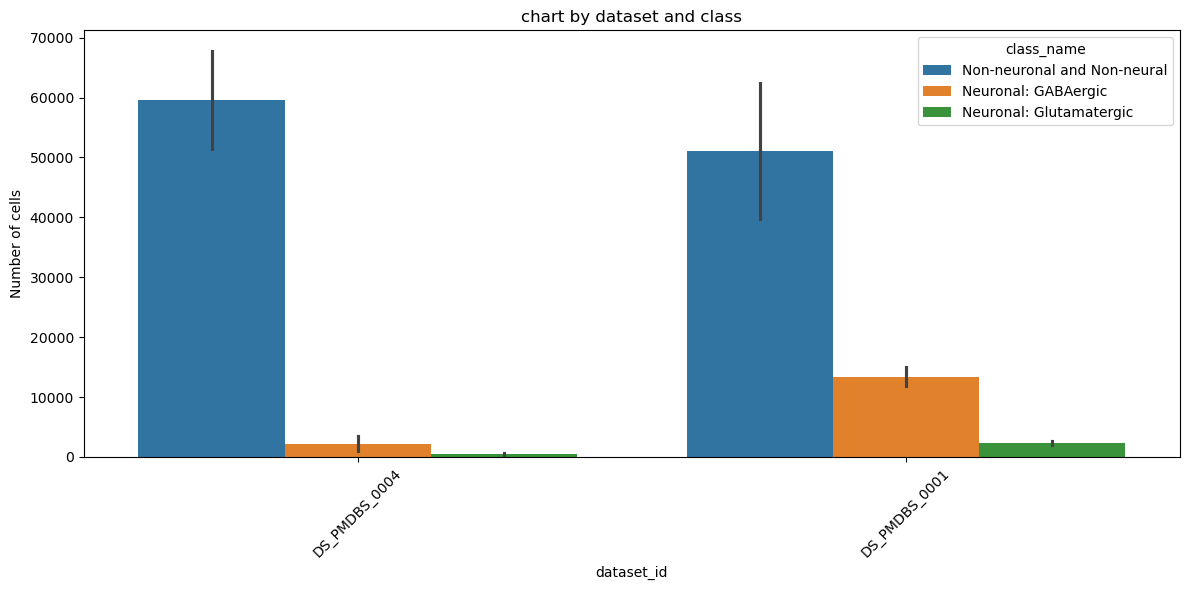

In [31]:
df = sn_ad.obs[["dataset_id","class_name","condition_id"]].astype(str)

# Count occurrences of each combination
count_df = df.value_counts().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.barplot(
    data=count_df,
    x="dataset_id",
    y="count",
    hue="class_name"
)
plt.xticks(rotation=45)
plt.ylabel("Number of cells")
plt.title("chart by dataset and class")
plt.tight_layout()
plt.show()


keeping PD and healthy together for now due to little number of neuronal cells

In [32]:
sn_ad.obs["cell_type"].value_counts()

cell_type
Oligodendrocyte    107844
Unknown            106570
Microglia-PVM       13588
Astrocyte           10465
OPC                  9038
Endothelial          4310
GABAergic            3976
VLMC                 2300
Glutamatergic         414
Name: count, dtype: int64

In [33]:
# Use regex to match multiple patterns
neuronal_subset = sn_ad[sn_ad.obs["class_name"].str.contains("GABAergic|Glutamatergic", regex=True)].copy()

In [34]:
neuronal_subset

AnnData object with n_obs × n_vars = 36916 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'dataset_id', 'biobank_name'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res

In [35]:
#neuronal_subset.file.close()

### Export SN - SN Cell Subset

In [40]:
snn_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_neuronal_HVGonly.h5ad"
)
neuronal_subset.write_h5ad(snn_samples_filename)



### Load Full Gene Expression for the SN Subset

In [37]:
# Define file paths 
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)

if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

In [38]:
# Load full expression matrix
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

In [39]:
# Extract and select neuronal_subset cells from complete gene expression matrix
var_ = full_adata.var.copy()
X = full_adata[sn_ad.obs_names].X.copy()

full_adata.file.close()

combine the full gene expression matrix with our substantia nigra neuron subset, and save the resulting AnnDataobject.

In [41]:
sn_full_ad = sc.AnnData(
    X=X,
    obs=sn_ad.obs,
    var=var_,
    uns=sn_ad.uns,
    obsm=sn_ad.obsm,
)
sn_full_ad

AnnData object with n_obs × n_vars = 258505 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'dataset_id', 'biobank_name'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_r

In [42]:
# Save full sn neuronal Anndata object
sn_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_ad.h5ad"
)
sn_full_ad.write_h5ad(sn_full_samples_filename)

## Run MapMyCells

In [5]:
#if starting from here 
sn_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_ad.h5ad"
)
#sn_full_ad = sc.read_h5ad(sn_full_samples_filename)

In [30]:
sn_full_ad

AnnData object with n_obs × n_vars = 258505 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'dataset_id', 'biobank_name'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_r

In [65]:
# Set paths
precomputed_stats_filepath = ( mapmycells_input_dir / "Human.precomputed_stats.20250507.h5" )
query_markers_filepath =  ( mapmycells_input_dir / "Human.query_markers.20250507.json" )

In [60]:
# grab taxonomy files 
#! wget "https://released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com/HMBA/BasalGanglia/BICAN_05072025_pre-print_release/MapMyCells/Human.precomputed_stats.20250507.h5" -O {precomputed_stats_filepath}
#! wget "https://released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com/HMBA/BasalGanglia/BICAN_05072025_pre-print_release/MapMyCells/Human.query_markers.20250507.json" -O {query_markers_filepath}

--2025-12-04 15:58:19--  https://released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com/HMBA/BasalGanglia/BICAN_05072025_pre-print_release/MapMyCells/Human.precomputed_stats.20250507.h5
3.5.84.148, 52.92.227.226, 52.92.148.202, ...-west-2.s3.us-west-2.amazonaws.com (released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com)... 
connected. to released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com (released-taxonomies-802451596237-us-west-2.s3.us-west-2.amazonaws.com)|3.5.84.148|:443... 
200 OKequest sent, awaiting response... 
Length: 755535936 (721M) [binary/octet-stream]
Saving to: ‘/home/jupyter/workspace/ws_files/case_study_01/mapmycells/input/Human.precomputed_stats.20250507.h5’

/home/jupyter/works 100%[===================>] 720.54M  20.4MB/s    in 36s     

2025-12-04 15:58:55 (19.9 MB/s) - ‘/home/jupyter/workspace/ws_files/case_study_01/mapmycells/input/Human.precomputed_stats.20250507.h5’ saved [755535936/755535936]

--2025-12-04 15:59:

In [10]:
import json
import cell_type_mapper
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from cell_type_mapper.cli.from_specified_markers import FromSpecifiedMarkersRunner

In [11]:
# have to use ENSG ids for this mapmycells taxonomy
# prep data

# Preserve gene_name as a column
adata_mmc = sn_full_ad.copy()
adata_mmc.var["gene_name"] = adata_mmc.var.index

# 2. Set var_names to gene_id (ENSG IDs)
adata_mmc.var_names = adata_mmc.var["gene_id"].astype(str)

# 3. Ensure uniqueness
adata_mmc.var_names_make_unique()

# Quick check
print(adata_mmc.var.head())
print(adata_mmc.var_names[:5])

adata_mmc_filename = ( mapmycells_input_dir / "sn_mapmycells_input.h5ad" )
adata_mmc.write_h5ad(adata_mmc_filename)


                    feature_type  genome          gene_id     mt     rb  \
gene_id                                                                   
ENSG00000243485  Gene Expression  GRCh38  ENSG00000243485  False  False   
ENSG00000237613  Gene Expression  GRCh38  ENSG00000237613  False  False   
ENSG00000186092  Gene Expression  GRCh38  ENSG00000186092  False  False   
ENSG00000238009  Gene Expression  GRCh38  ENSG00000238009  False  False   
ENSG00000239945  Gene Expression  GRCh38  ENSG00000239945  False  False   

                   gene_name  
gene_id                       
ENSG00000243485  MIR1302-2HG  
ENSG00000237613      FAM138A  
ENSG00000186092        OR4F5  
ENSG00000238009   AL627309.1  
ENSG00000239945   AL627309.3  
Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945'],
      dtype='object', name='gene_id')


In [12]:
sn_full_ad.file.close()
adata_mmc_filename = ( mapmycells_input_dir / "sn_mapmycells_input.h5ad" )
adata_mmc = sc.read_h5ad(adata_mmc_filename)

In [23]:
marker_ids = set()

for node, marker_list in query_markers.items():
    if marker_list is None:
        continue
    # Each marker_list is already a list of ENSG IDs
    marker_ids.update(marker_list)

print(f"Collected {len(marker_ids)} unique marker IDs across all nodes")


Collected 6852 unique marker IDs across all nodes


In [25]:
overlap = marker_ids.intersection(set(adata_mmc.var_names))
print(f"Overlap with taxonomy markers: {len(overlap)} genes")

Overlap with taxonomy markers: 6733 genes


In [31]:
import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


# paths to files where mapping output will be written
json_dst_path = str( mapmycells_output_dir / "human_sn_mapping.json") 
csv_dst_path = str( mapmycells_output_dir / "human_sn_neruons_mapping.csv")


config = {
    "query_path": str(adata_mmc_filename),
    "extended_result_path": json_dst_path,
    "csv_result_path": csv_dst_path,
    "verbose_csv": True,
    "query_markers": {
       "serialized_lookup":str(query_markers_filepath)
    },
    "precomputed_stats": {
        "path": str(precomputed_stats_filepath)
    },
    "type_assignment": {
        "n_processors": 4,
        "normalization": "raw",
        "bootstrap_factor": 0.5,
        "bootstrap_iteration": 100
    }
}

In [32]:
# run map my cells
runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=config
)
runner.run()

=== Running Hierarchical Mapping 1.5.2 with config ===
{
  "obsm_clobber": false,
  "query_path": "/home/jupyter/workspace/ws_files/case_study_01/mapmycells/input/sn_mapmycells_input.h5ad",
  "summary_metadata_path": null,
  "verbose_csv": true,
  "max_gb": 100.0,
  "precomputed_stats": {
    "log_level": "ERROR",
    "path": "/home/jupyter/workspace/ws_files/case_study_01/mapmycells/input/Human.precomputed_stats.20250507.h5"
  },
  "extended_result_dir": null,
  "tmp_dir": null,
  "nodes_to_drop": null,
  "drop_level": null,
  "type_assignment": {
    "log_level": "ERROR",
    "bootstrap_factor": 0.5,
    "bootstrap_iteration": 100,
    "bootstrap_factor_lookup": null,
    "rng_seed": 11235813,
    "n_runners_up": 5,
    "min_markers": 10,
    "normalization": "raw",
    "chunk_size": 10000,
    "n_processors": 4
  },
  "hdf5_result_path": null,
  "obsm_key": null,
  "extended_result_path": "/home/jupyter/workspace/ws_files/case_study_01/mapmycells/output/human_sn_mapping.json",
  "ma

/opt/conda/envs/scvi-cells/lib/python3.10/site-packages/cell_type_mapper/taxonomy/utils.py:253: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "


BENCHMARK: spent 1.9260e-01 seconds creating query marker cache
Running CPU implementation of type assignment.
40000 of 258505 cells in 2.06e+00 min; predict 1.13e+01 min of 1.33e+01 min left
50000 of 258505 cells in 2.71e+00 min; predict 1.13e+01 min of 1.40e+01 min left
60000 of 258505 cells in 3.09e+00 min; predict 1.02e+01 min of 1.33e+01 min left
70000 of 258505 cells in 3.26e+00 min; predict 8.78e+00 min of 1.20e+01 min left
80000 of 258505 cells in 3.53e+00 min; predict 7.87e+00 min of 1.14e+01 min left
90000 of 258505 cells in 4.08e+00 min; predict 7.65e+00 min of 1.17e+01 min left
100000 of 258505 cells in 4.43e+00 min; predict 7.01e+00 min of 1.14e+01 min left
110000 of 258505 cells in 4.82e+00 min; predict 6.51e+00 min of 1.13e+01 min left
120000 of 258505 cells in 5.08e+00 min; predict 5.86e+00 min of 1.09e+01 min left
130000 of 258505 cells in 5.60e+00 min; predict 5.53e+00 min of 1.11e+01 min left
140000 of 258505 cells in 5.89e+00 min; predict 4.98e+00 min of 1.09e+01 mi

In [6]:
mmc_mapping_filename = ( mapmycells_output_dir / "human_sn_neruons_mapping.csv" )
mmc_res = pd.read_csv(mmc_mapping_filename, comment='#')
mmc_res.columns

Index(['cell_id', 'Neighborhood_label', 'Neighborhood_name',
       'Neighborhood_bootstrapping_probability',
       'Neighborhood_aggregate_probability',
       'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name',
       'Class_bootstrapping_probability', 'Class_aggregate_probability',
       'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name',
       'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability',
       'Subclass_correlation_coefficient', 'Group_label', 'Group_name',
       'Group_bootstrapping_probability', 'Group_aggregate_probability',
       'Group_correlation_coefficient', 'Cluster_label', 'Cluster_name',
       'Cluster_alias', 'Cluster_bootstrapping_probability',
       'Cluster_aggregate_probability', 'Cluster_correlation_coefficient'],
      dtype='object')

Assess Mapmycells results

In [7]:
mmc_res.Neighborhood_name.value_counts()

Neighborhood_name
Nonneuron               241477
Subpallium GABA          11887
Glut Sero Dopa            4576
Subpallium GABA-Glut       565
Name: count, dtype: int64

In [8]:
mmc_res.Class_name.value_counts()

Class_name
OPC-Oligo       189420
Astro-Epen       20650
Immune           16990
Vascular         14417
F M GABA          5310
CN MGE GABA       3961
F M Glut          3862
CN CGE GABA       1145
CN LGE GABA       1073
M Dopa             714
CN GABA-Glut       565
Cx GABA            398
Name: count, dtype: int64

In [13]:
# Set index to cell_id for easy alignment
mapmycells_df = mmc_res.set_index("cell_id")

# validate connection 
print(len(set(mapmycells_df.index).intersection(set(adata_mmc.obs_names))))


258505


In [14]:
## Integrate adata and mapmycell results
# Add taxonomy labels
adata_mmc.obs["mmc_neighborhood"] = mapmycells_df.loc[adata_mmc.obs_names, "Neighborhood_name"]
adata_mmc.obs["mmc_class"] = mapmycells_df.loc[adata_mmc.obs_names, "Class_name"]

# add confidence scores
if "Neighborhood_bootstrapping_probability" in mapmycells_df.columns:
    adata_mmc.obs["mmc_neighborhood_btstrap_prob"] = mapmycells_df.loc[adata_mmc.obs_names, "Neighborhood_bootstrapping_probability"]

if "Class_name" in mapmycells_df.columns:
    adata_mmc.obs["mmc_class_btstrp_prob"] = mapmycells_df.loc[adata_mmc.obs_names, "Class_bootstrapping_probability"]

In [15]:
adata_mmc.obs.head()

background_fraction  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....             0.001121   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....             0.001840   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....             0.001939   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....             0.002002   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....             0.001816   

                                                    cell_probability  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....          0.999955   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....          0.999955   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....          0.999955   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....          0.999955   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....          0.999955   

                                                       cell_size  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....  11219.375000   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....   9410.469727   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....   9162.027344   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....   8497.646484   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....   8109.090820   

                                                    droplet_efficiency  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....            2.093091   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....            2.112596   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....            2.059060   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....            2.098572   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....            2.085751   

                                                    n_genes_by_counts  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....               6163   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....               5715   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....               5492   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....               5599   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....               5224   

                                                    total_counts  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....         23165   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....         19527   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....         18527   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....         17444   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....         16489   

                                                    total_counts_rb  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....              118   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....              131   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....              142   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....              197   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....              131   

                                                    pct_counts_rb  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....       0.509389   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....       0.670866   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....       0.766449   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....       1.129328   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....       0.794469   

                                                    total_counts_mt  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....              106   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1....              152   
CCTCAGTGTCATCCCT-1_ASAP_PMBDS_000001_s003_rep1....              165   
GGGTTGCGTTGACGTT-1_ASAP_PMBDS_000001_s003_rep1....              341   
CATCGGGGTAACGCGA-1_ASAP_PMBDS_000001_s003_rep1....              123   

                                                    pct_counts_mt  ...  \
TCGGTAAGTGACTACT-1_ASAP_PMBDS_000001_s003_rep1....       0.457587  ...   
AGAGCTTTCTTCGAGA-1_ASAP_PMBDS_000001_s003_rep1...

In [18]:
# define low-confidence threshold --> unknown
conf_thresh = 0.7
labels = adata_mmc.obs["mmc_class"].copy()

# mark low-confidence cells as Unknown
low_conf_mask = adata_mmc.obs["mmc_class_btstrp_prob"] < conf_thresh
labels[low_conf_mask] = "Unknown"

# save refined labels
adata_mmc.obs["mmc_class_refined_1"] = labels

# quick check
print(adata_mmc.obs["mmc_class_refined_1"].value_counts())


mmc_class_refined_1
OPC-Oligo       181095
Unknown          20414
Astro-Epen       18784
Immune           16257
Vascular         11497
F M Glut          3713
F M GABA          3173
CN MGE GABA       1568
CN CGE GABA        638
M Dopa             568
CN GABA-Glut       565
CN LGE GABA        165
Cx GABA             68
Name: count, dtype: int64


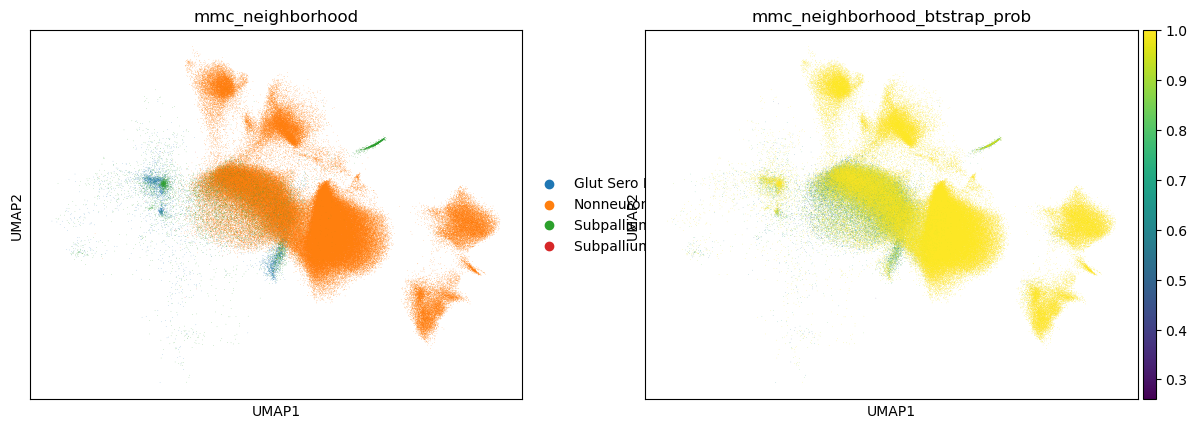

In [19]:
sc.pl.umap(adata_mmc, color=["mmc_neighborhood", "mmc_neighborhood_btstrap_prob"])

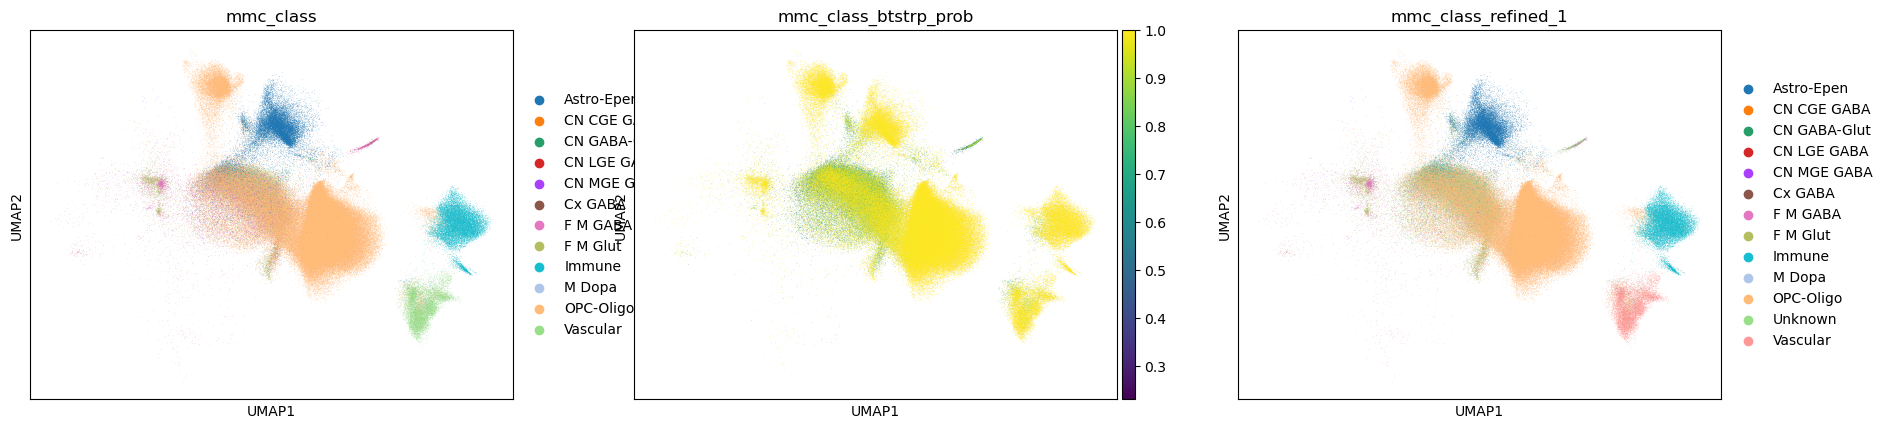

In [20]:
sc.pl.umap(adata_mmc, color=["mmc_class", "mmc_class_btstrp_prob", "mmc_class_refined_1"])

In [21]:
# move gene names back to index for readability
# 2. Set var_names to gene_names
adata_mmc.var_names = adata_mmc.var["gene_name"].astype(str)

# 3. Ensure uniqueness
adata_mmc.var_names_make_unique()

# Quick check
print(adata_mmc.var.head())
print(adata_mmc.var_names[:5])

mmc_adata_output_filepath = ( mapmycells_output_dir / "sn_mapmycells_integrated_output.h5ad")
adata_mmc.write_h5ad(mmc_adata_output_filepath)

                feature_type  genome          gene_id     mt     rb  \
gene_name                                                             
MIR1302-2HG  Gene Expression  GRCh38  ENSG00000243485  False  False   
FAM138A      Gene Expression  GRCh38  ENSG00000237613  False  False   
OR4F5        Gene Expression  GRCh38  ENSG00000186092  False  False   
AL627309.1   Gene Expression  GRCh38  ENSG00000238009  False  False   
AL627309.3   Gene Expression  GRCh38  ENSG00000239945  False  False   

               gene_name  
gene_name                 
MIR1302-2HG  MIR1302-2HG  
FAM138A          FAM138A  
OR4F5              OR4F5  
AL627309.1    AL627309.1  
AL627309.3    AL627309.3  
Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object', name='gene_name')


## Process data 
- Normalize 
- Log transform 
- Re-calculate HVG for SN region subset
- Perform PCA
- Calculate Neighbors using global scVI 
- Leiden cluster at different resolutions

### DA marker genes: 
- [TH](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TH&keywords=TH)
- [DDC](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DDC&keywords=DDC)
- [SLC6A3](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC6A3&keywords=SLC6A3)
- [NR4A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NR4A2)
- [SLC18A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC18A2&keywords=SLC18A2)

Together, these genes capture three essential aspects of the dopamine neuron phenotype:
1. Dopamine synthesis — TH, DDC
2. Dopamine storage and synaptic handling — SLC6A3, SLC18A2
3. Transcriptional identity and maintenance — NR4A2

Resources: 
- [https://www.nature.com/articles/s41593-022-01061-1](https://www.nature.com/articles/s41593-022-01061-1)
- [https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6](https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6)
- [https://www.pnas.org/doi/10.1073/pnas.2410331121](https://www.pnas.org/doi/10.1073/pnas.2410331121)
- [https://pmc.ncbi.nlm.nih.gov/articles/PMC7285906/](https://pmc.ncbi.nlm.nih.gov/articles/PMC7285906/)
- [https://elifesciences.org/articles/101035#s2](https://elifesciences.org/articles/101035#s2)
- [https://www.science.org/doi/10.1126/sciadv.adi8287](https://www.science.org/doi/10.1126/sciadv.adi8287)


In [10]:
#starting from here: 
mmc_adata_output_filepath = ( 
    mapmycells_output_dir / 
    "sn_mapmycells_integrated_output.h5ad"
)
adata_mmc = sc.read_h5ad(mmc_adata_output_filepath)

In [11]:
# set DA marker genes
marker_genes = ["TH", "DDC", "SLC6A3", "NR4A2", "SLC18A2"]

In [12]:
# work on tmp copy
adata_neurons_tmp = adata_mmc.copy()
# keep raw in counts layer
adata_neurons_tmp.layers["counts"] = adata_neurons_tmp.X.copy() 

sc.pp.normalize_total(adata_neurons_tmp, target_sum=1e4)
sc.pp.log1p(adata_neurons_tmp)

# detect hvg of SN subset
hvgs_res =sc.experimental.pp.highly_variable_genes(
        adata_neurons_tmp,
        n_top_genes=3000,
        batch_key="sample", #using sample not batch
        flavor="pearson_residuals",
        check_values=True,
        layer="counts",
        subset=False,
        inplace=False
)

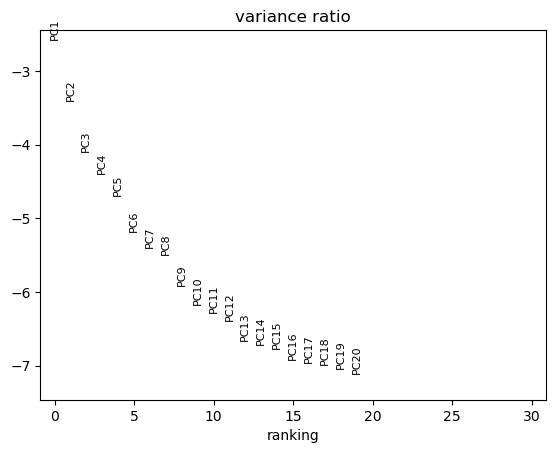

In [13]:
# PCA for QC diagnostics
sc.tl.pca(adata_neurons_tmp, svd_solver="arpack", n_comps=20)
sc.pl.pca_variance_ratio(adata_neurons_tmp, log=True)

adata_neurons_tmp.obsm["X_scVI"] = adata_neurons_tmp.obsm["X_scVI"].astype("float32")
# Neighborhood graph using scVI embedding
sc.pp.neighbors(adata_neurons_tmp, use_rep="X_scVI", n_neighbors=30)

In [14]:
sc.tl.leiden(adata_neurons_tmp, resolution=1.0, key_added="leiden_sn_scVI_1.0", random_state=0)

In [15]:
# Score DA neuron markers
# validate presence of marker genes
marker_genes = ["TH", "DDC", "SLC6A3", "NR4A2", "SLC18A2"]
for g in marker_genes:
    assert g in adata_neurons_tmp.var_names, f"{g} not found in var_names!"
existing_markers = [g for g in marker_genes if g in adata_neurons_tmp.var_names]
sc.tl.score_genes(adata_neurons_tmp, existing_markers, score_name="DA_score")

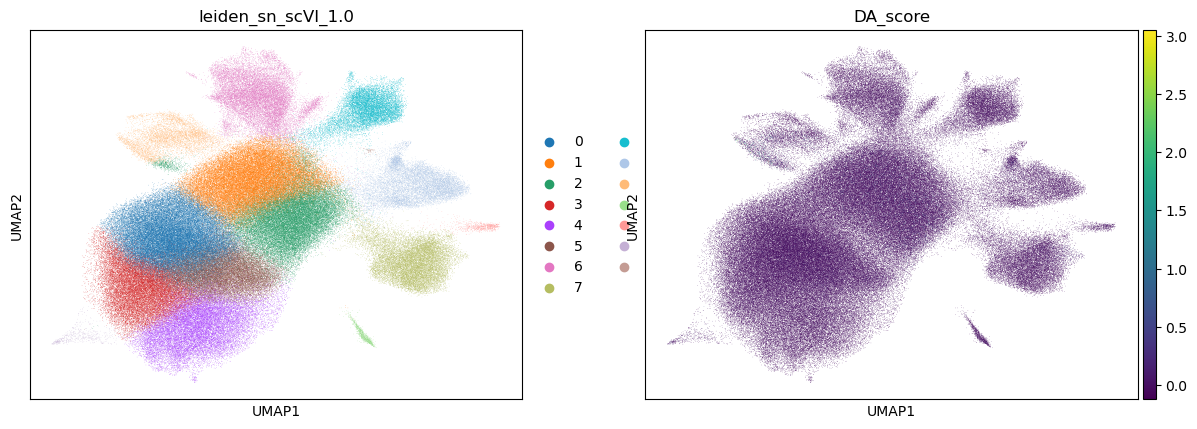

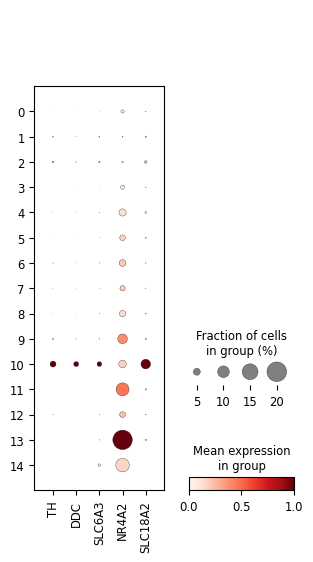

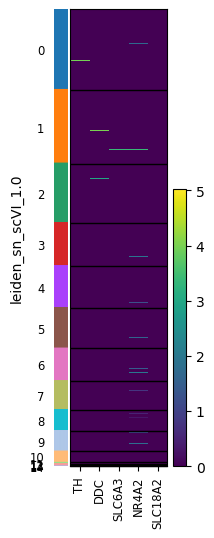

In [16]:
cluster_key = "leiden_sn_scVI_1.0"
# UMAP from scVI neighbors
sc.tl.umap(adata_neurons_tmp)

# UMAP overlays: clusters and DA score
sc.pl.umap(adata_neurons_tmp, color=[cluster_key, "DA_score"], cmap="viridis")

# Dotplot and heatmap for DA markers across clusters
sc.pl.dotplot(adata_neurons_tmp, existing_markers, groupby=cluster_key, standard_scale="var")
sc.pl.heatmap(adata_neurons_tmp, existing_markers, groupby=cluster_key, use_raw=False)


/tmp/ipykernel_1169/2986547470.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)["DA_score"]
/tmp/ipykernel_1169/2986547470.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


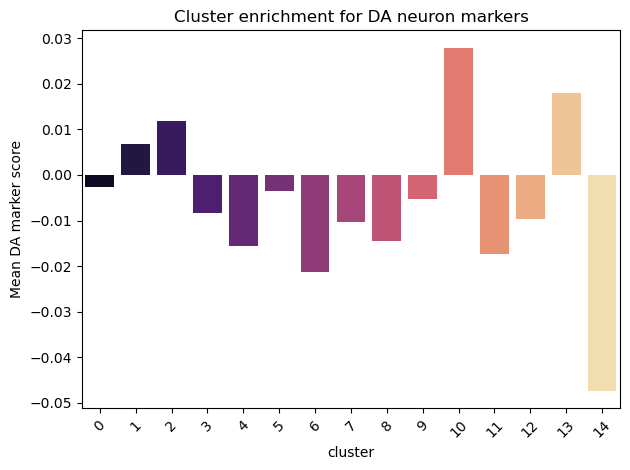

In [17]:
# Group by cluster and compute mean DA_score
cluster_means = (
    adata_neurons_tmp.obs
    .groupby(cluster_key)["DA_score"]
    .mean()
    .reset_index()
    .rename(columns={cluster_key: "cluster"})
)


sns.barplot(
    data=cluster_means.reset_index().rename(columns={cluster_key: "cluster"}),
    x="cluster",
    y="DA_score",
    palette="magma"
)
plt.xticks(rotation=45)
plt.ylabel("Mean DA marker score")
plt.title("Cluster enrichment for DA neuron markers")
plt.tight_layout()
plt.show()

In [18]:
print(cluster_means)

   cluster  DA_score
0        0 -0.002650
1        1  0.006847
2        2  0.011807
3        3 -0.008246
4        4 -0.015480
5        5 -0.003479
6        6 -0.021271
7        7 -0.010313
8        8 -0.014452
9        9 -0.005173
10      10  0.027985
11      11 -0.017255
12      12 -0.009577
13      13  0.017890
14      14 -0.047438


Text(0.5, 1.0, 'DA score distributions')

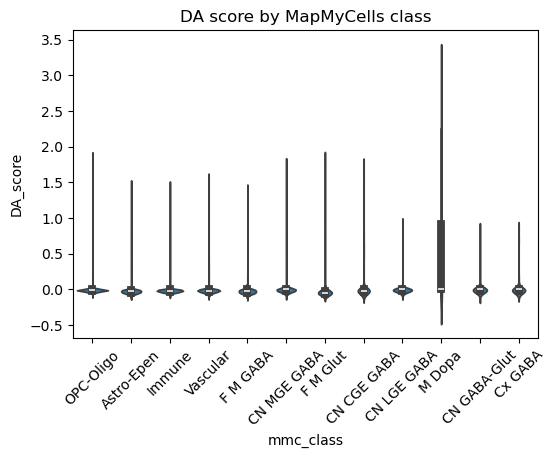

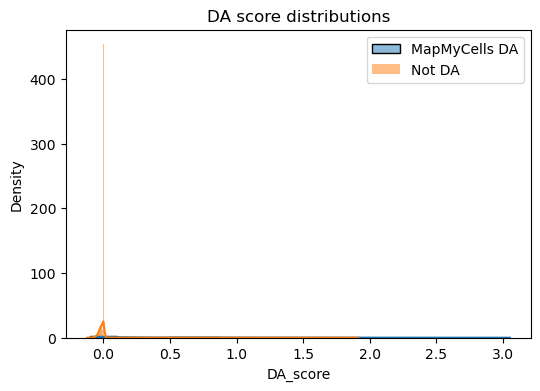

In [20]:
# binary labels
adata_neurons_tmp.obs["is_mmc_DA"] = adata_neurons_tmp.obs["mmc_class"] == "M Dopa"

# Violin by class
plt.figure(figsize=(6,4))
sns.violinplot(x="mmc_class", y="DA_score", data=adata_neurons_tmp.obs, order=adata_neurons_tmp.obs["mmc_class"].value_counts().index)
plt.xticks(rotation=45)
plt.title("DA score by MapMyCells class")

# Histogram overlay
plt.figure(figsize=(6,4))
sns.histplot(adata_neurons_tmp.obs.loc[adata_neurons_tmp.obs["is_mmc_DA"], "DA_score"], color="C0", label="MapMyCells DA", stat="density", kde=True)
sns.histplot(adata_neurons_tmp.obs.loc[~adata_neurons_tmp.obs["is_mmc_DA"], "DA_score"], color="C1", label="Not DA", stat="density", kde=True)
plt.legend()
plt.title("DA score distributions")

In [21]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix
# correlation
corr = adata_neurons_tmp.obs[["DA_score","mmc_class_btstrp_prob"]].dropna().corr().iloc[0,1]
print("Pearson corr (DA_score vs mmc_class_btstrp_prob):", corr)

# ROC AUC (DA_score predicting MapMyCells DA)
y_true = adata_neurons_tmp.obs["is_mmc_DA"].astype(int)
y_score = adata_neurons_tmp.obs["DA_score"].fillna(0).values
auc = roc_auc_score(y_true, y_score)
print("ROC AUC (DA_score -> MapMyCells DA):", auc)

# Precision/recall at DA_score threshold 
score_thresh = np.quantile(adata_neurons_tmp.obs["DA_score"].dropna(), 0.75)
y_pred = (adata_neurons_tmp.obs["DA_score"] >= score_thresh).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)


Pearson corr (DA_score vs mmc_class_btstrp_prob): -0.06333899139329398
ROC AUC (DA_score -> MapMyCells DA): 0.7675683894669543
Precision: 0.005, Recall: 0.759, F1: 0.011
Confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[155854 101937]
 [   172    542]]


### Refine DA assignment based on DA score and MapMyCells label 

In [22]:
# apply thresholds and create refined column
obs = adata_neurons_tmp.obs
prob_thresh = 0.7
# ensure DA_score and mmc_class_btstrp_prob exist
assert "DA_score" in obs.columns, "DA_score missing"
assert "mmc_class_btstrp_prob" in obs.columns, "mmc_class_btstrp_prob missing"
assert "mmc_class_refined_1" in obs.columns, "mmc_class_refined_1 missing"

# create boolean masks
is_m_dopa = obs["mmc_class_refined_1"] == "M Dopa"
high_score = obs["DA_score"] >= score_thresh
high_prob = obs["mmc_class_btstrp_prob"] >= prob_thresh

# new refined label
refined = obs["mmc_class_refined_1"].copy()
# move M Dopa to Unknown unless both conditions true
refined.loc[is_m_dopa & ~(high_score & high_prob)] = "Unknown"
adata_neurons_tmp.obs["mmc_class_refined_2"] = refined


In [23]:
# refined counts
print("Before refinement")
print(obs["mmc_class_refined_1"].value_counts())
print("\nAfter refinement")
print(adata_neurons_tmp.obs["mmc_class_refined_2"].value_counts())

Before refinement
mmc_class_refined_1
OPC-Oligo       181095
Unknown          20414
Astro-Epen       18784
Immune           16257
Vascular         11497
F M Glut          3713
F M GABA          3173
CN MGE GABA       1568
CN CGE GABA        638
M Dopa             568
CN GABA-Glut       565
CN LGE GABA        165
Cx GABA             68
Name: count, dtype: int64

After refinement
mmc_class_refined_2
OPC-Oligo       181095
Unknown          20527
Astro-Epen       18784
Immune           16257
Vascular         11497
F M Glut          3713
F M GABA          3173
CN MGE GABA       1568
CN CGE GABA        638
CN GABA-Glut       565
M Dopa             455
CN LGE GABA        165
Cx GABA             68
Name: count, dtype: int64


In [24]:
# saving h5ad
mmc_adata_output_proc_filepath = ( mapmycells_output_dir / 
                             "sn_mapmycells_integrated_processed_output.h5ad")
adata_neurons_tmp.write_h5ad(mmc_adata_output_proc_filepath)

In [27]:
# saving hvgs_res
hvgs_res_filepath = ( mapmycells_output_dir / 
                             "sn_hvgs_results.csv")
hvgs_res.to_csv(hvgs_res_filepath)

### Option to export now --> this might be good enough for gene x celltype matrix

In [15]:
# assume adata.obs["condition_id"] has values like "control" and "PD"
adata_control = adata_neurons_tmp[adata_neurons_tmp.obs["condition_id"] == "Control"].copy()
adata_case    = adata_neurons_tmp[adata_neurons_tmp.obs["condition_id"] == "PD"].copy()


In [18]:
adata_neurons_tmp.obs["condition_id"].value_counts()

condition_id
PD         132940
Control    125565
Name: count, dtype: int64

In [21]:
adata_neurons_tmp.obs["biobank_name"].value_counts()

biobank_name
Banner Sun Health Research Institute    133801
Cambridge Brain Bank                    124704
Name: count, dtype: int64

In [22]:
#simple aggregation function to get sum gene exp per cell type 
# or median gene exp per celltype
def aggregate_by_celltype(adata, aggfunc="median"):
    # choose counts layer if available
    X = adata.layers["counts"] if "counts" in adata.layers else adata.X
    df = pd.DataFrame(
        X.toarray() if hasattr(X, "toarray") else X,
        index=adata.obs_names,
        columns=adata.var_names
    )
    df["cell_type"] = adata.obs["cell_type"].values
    return df.groupby("cell_type").agg(aggfunc).T


In [ ]:
# control
control_median = aggregate_by_celltype(adata_control, "median")
control_sum    = aggregate_by_celltype(adata_control, "sum")

# PD case
case_median = aggregate_by_celltype(adata_case, "median")
case_sum    = aggregate_by_celltype(adata_case, "sum")

# combined (all samples together)
all_median = aggregate_by_celltype(adata, "median")
all_sum    = aggregate_by_celltype(adata, "sum")

In [ ]:
# create folders
round1_output_dir = ( cohort_analysis_path / output_matrices )
os.makedirs(round1_output_dir, exist_ok=True)

folders = ["case", "control", "all"]
sum_dfs = [control_sum, case_sum, all_sum]
median_dfs = [control_median, case_median, all_median]

for folder in folders:
    os.makedirs( (round1_output_dir / folder), exist_ok=True)

control_median.to_csv((round1_output_dir / "control" /"median_counts.csv"))
control_sum.to_csv((round1_output_dir / "control" /"sum_counts.csv"))

case_median.to_csv((round1_output_dir / "case" /"median_counts.csv"))
case_sum.to_csv((round1_output_dir / "case" /"sum_counts.csv"))

all_median.to_csv((round1_output_dir / "all" / "median_counts.csv"))
all_sum.to_csv((round1_output_dir / "all" / "sum_counts.csv"))


## Train scANVI

- decision forks:
    - using HVGs or complete gene set for scANVI (USING HVG FOR SPEED) --> KEEPS DYING for cpu, running in GPU
    - Training vs fine-tuning previous scANVI model; training due to different granularity of cell composition.
    - balancing seeds across classes, did not do because the smallest cluster is ~100 cells 

In [7]:
# if starting here
mmc_adata_output_proc_filepath = ( mapmycells_output_dir / 
                             "sn_mapmycells_integrated_processed_output.h5ad")
adata_neurons_tmp = sc.read_h5ad(mmc_adata_output_proc_filepath)
hvgs_res_filepath = ( mapmycells_output_dir / 
                             "sn_hvgs_results.csv")
hvgs_res = pd.read_csv(hvgs_res_filepath, index_col = 0)

In [ ]:
#CONFIG
BATCH_KEY = "sample"  
CLUSTER_KEY =  "leiden_sn_scVI_1.0"
NEW_LABELS_COL = "mmc_class_refined_2" 
EXTERNAL_LABELS_COL = "mmc_class"
UNLABELED_TOKEN = "Unknown"

# Marker panels
DA_MARKERS = ["TH","DDC","SLC6A3","NR4A2","SLC18A2"]

In [9]:
# # Balance seeds across classes
# rng = np.random.default_rng(0)
# classes = adata_neurons_tmp.obs.mmc_class_refined_2.unique().tolist()
# adata_neurons_tmp.obs[NEW_LABELS_COL] = adata_neurons_tmp.obs.mmc_class_refined_2
# counts = adata_neurons_tmp.obs[NEW_LABELS_COL].value_counts()
# n_min = min(counts.get(c,0) for c in classes if counts.get(c,0)>0)
# adata_neurons_tmp.obs["subsample_status"] = "not_subsampled"
# for c in classes:
#     idx = np.where(adata_neurons_tmp.obs[NEW_LABELS_COL].values == c)[0]
#     if len(idx) > n_min and n_min > 0:
#         keep = rng.choice(idx, size=n_min, replace=False)
#         drop = np.setdiff1d(idx, keep)
#         adata_neurons_tmp.obs.iloc[keep, adata_neurons_tmp.obs.columns.get_loc("subsample_status")] = f"kept_{c}"
#         adata_neurons_tmp.obs.iloc[drop, adata_neurons_tmp.obs.columns.get_loc("subsample_status")] = f"dropped_{c}"
#         adata_neurons_tmp.obs.iloc[drop, adata_neurons_tmp.obs.columns.get_loc(NEW_LABELS_COL)] = UNLABELED_TOKEN

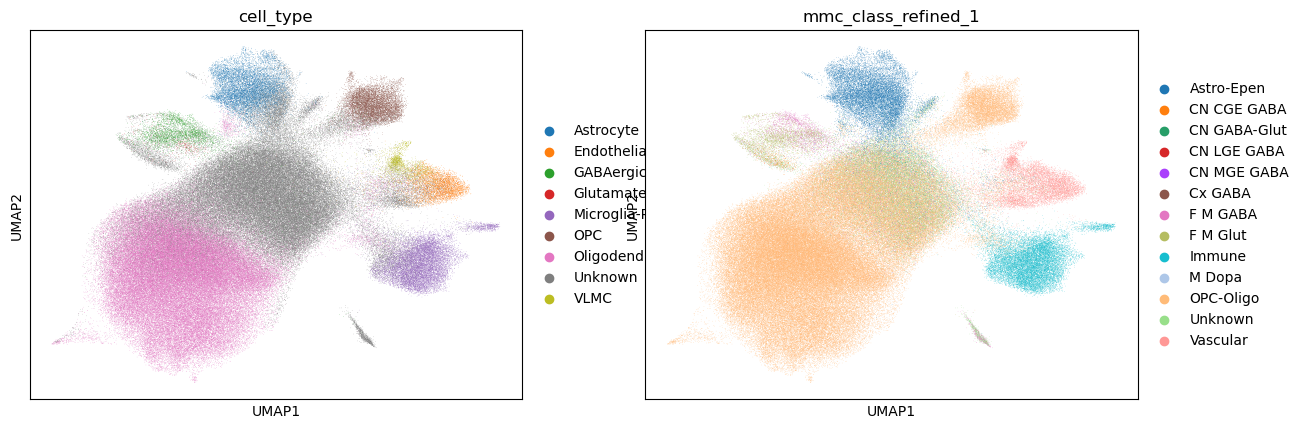

In [10]:
sc.pl.umap(adata_neurons_tmp, color=[ "cell_type", "mmc_class_refined_1"], cmap="viridis")

In [11]:
if hasattr(hvgs_res, "index"):
    hvgs = hvgs_res.index[hvgs_res["highly_variable"]].tolist() if "highly_variable" in hvgs_res.columns else hvgs_res.index.tolist()
else:
    hvgs = list(hvgs_res)

# 2. add marker genes (ensure they are in the same namespace as adata.var_names)
marker_genes = ["TH","DDC","SLC6A3","SLC18A2","NR4A2"]  

# keep only genes present in adata
hvgs = [g for g in hvgs if g in adata_neurons_tmp.var_names]
markers_present = [g for g in marker_genes if g in adata_neurons_tmp.var_names]
gene_set = list(dict.fromkeys(hvgs + markers_present))  # preserve order, dedupe

print(f"HVGS found: {len(hvgs)}; markers present: {len(markers_present)}; final gene set: {len(gene_set)}")

HVGS found: 3000; markers present: 5; final gene set: 3004


In [12]:
adata_hvg = adata_neurons_tmp[:, gene_set].copy()

# sanity checks
assert all(g in adata_hvg.var_names for g in gene_set)
print("adata_hvg shape:", adata_hvg.shape)
# ensure counts layer exists
if "counts" not in adata_hvg.layers:
    raise ValueError("counts layer missing; scVI/scANVI expects raw counts in a layer named 'counts'")


adata_hvg shape: (258505, 3004)


# Run on GPU Instance to train

In [13]:
# Training scANVI model due to cell composition and specificity to SN 
scvi.model.SCANVI.setup_anndata(
    adata_hvg,
    layer="counts",
    batch_key=BATCH_KEY, #sample
    labels_key=NEW_LABELS_COL,
    unlabeled_category=UNLABELED_TOKEN
)

scanvi_model = scvi.model.SCANVI(adata_hvg,
    UNLABELED_TOKEN,
    dispersion = "gene-cell",
    gene_likelihood = "zinb",
    n_latent = 10,
    n_layers =2
)

scanvi_model.train(
    max_epochs=100,
    early_stopping=True,
    accelerator="gpu",
    devices = "1",
    early_stopping_patience=5,
    check_val_every_n_epoch=10
)

adata_hvg.obs["scanvi_labels"] = scanvi_model.predict()
probas = scanvi_model.predict(soft=True)
adata_hvg.obsm["scanvi_probas"] = probas
adata_hvg.obs["scanvi_confidence"] = probas.max(axis=1)


INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/envs/scvi-cells/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/envs/scvi-cells/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [1:37:42<00:00, 58.49s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.01e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:37:42<00:00, 58.63s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.01e+3]


In [14]:
# after training
scanvi_model_path = ( local_data_path / "scanvi/ sn_scanvi_model")
os.makedirs(scanvi_model_path, exist_ok=True)
scanvi_model.save(scanvi_model_path, overwrite=True)

<Axes: xlabel='epoch'>

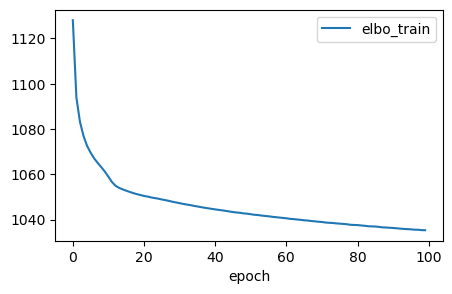

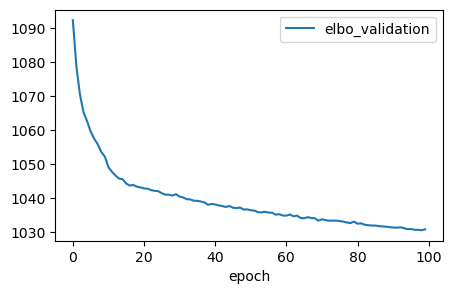

In [15]:
scanvi_model.history["elbo_train"].plot(figsize=(5,3)); scanvi_model.history["elbo_validation"].plot(figsize=(5,3))

In [21]:
# After training
hist = scanvi_model.history
print({k: hist[k][-1:] for k in ["elbo_train", "elbo_validation", "train_classification_loss","train_accuracy","train_f1_score"]})

# If you trained with validation:
# scanvi_model.train(..., check_val_every_n_epoch=10)
for k in ["elbo_validation", "elbo_validation","validation_classification_loss","validation_accuracy","validation_f1_score"]:
    if k in hist:
        print(k, hist[k][-1:])


{'elbo_train':         elbo_train
epoch             
99     1035.265381, 'elbo_validation':       elbo_validation
epoch                
99        1030.889404, 'train_classification_loss':       train_classification_loss
epoch                          
99                      0.01448, 'train_accuracy':       train_accuracy
epoch               
99          0.995205, 'train_f1_score':       train_f1_score
epoch               
99          0.995205}
elbo_validation       elbo_validation
epoch                
99        1030.889404
elbo_validation       elbo_validation
epoch                
99        1030.889404
validation_classification_loss       validation_classification_loss
epoch                               
99                           0.57199
validation_accuracy       validation_accuracy
epoch                    
99               0.802695
validation_f1_score       validation_f1_score
epoch                    
99               0.802695


{'elbo_train':         elbo_train
epoch             
99     1035.265381, 'elbo_validation':       elbo_validation
epoch                
99        1030.889404}


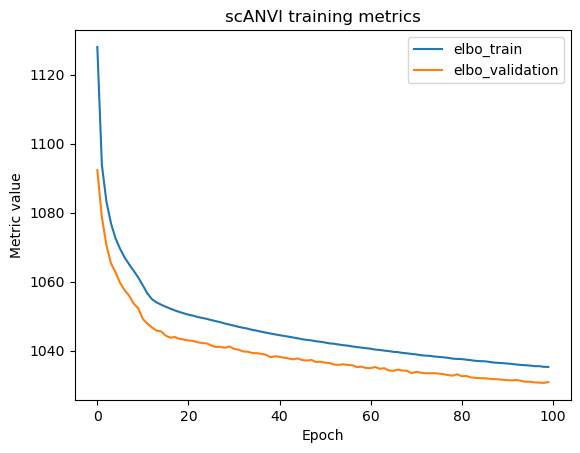

In [20]:

hist = scanvi_model.history
print({k: hist[k][-1:] for k in ["elbo_train","elbo_validation"]})

for k in ["elbo_train","elbo_validation"]:
    if k in hist:
        plt.plot(hist[k], label=k)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.title("scANVI training metrics")
plt.show()


could've done a few more epochs, but it doesn't look terrible

In [22]:
# Predict labels with scANVI
pred_labels = scanvi_model.predict()
#save
adata_hvg.obs["scanvi_labels"] = pred_labels

# extract confidence scores
probas = scanvi_model.predict(soft=True)
adata_hvg.obsm["scanvi_probas"] = probas
adata_hvg.obs["scanvi_confidence"] = probas.max(axis=1)

# Thresholding
thr = 0.7
adata_hvg.obs["scanvi_labels_conf"] = np.where(adata_hvg.obs["scanvi_confidence"] >= thr,
                                              scanvi_model.predict(),
                                              "Unknown")

In [ ]:
sns.histplot(adata_hvg.obs["scanvi_confidence"], bins=50, kde=True)
plt.xlabel("SCANVI confidence score")
plt.ylabel("Number of cells")
plt.title("Distribution of SCANVI confidence")
plt.show()


In [ ]:
sns.violinplot(x=adata_hvg.obs["scanvi_labels"], 
               y=adata_hvg.obs["scanvi_confidence"])
plt.xticks(rotation=90)
plt.ylabel("Confidence")
plt.title("Confidence by SCANVI predicted label")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
X = adata_hvg.obsm["X_scVI"]

lbl = adata_hvg.obs["scanvi_labels_conf"].astype(str)
sample = adata_hvg.obs["sample"].astype(str)

s_lbl = silhouette_score(X, lbl)
s_sample = silhouette_score(X, reg)
print(f"Silhouette(cell type)={s_lbl:.3f} vs Silhouette(sample)={s_sample:.3f}")


In [ ]:
adata_hvg.obs

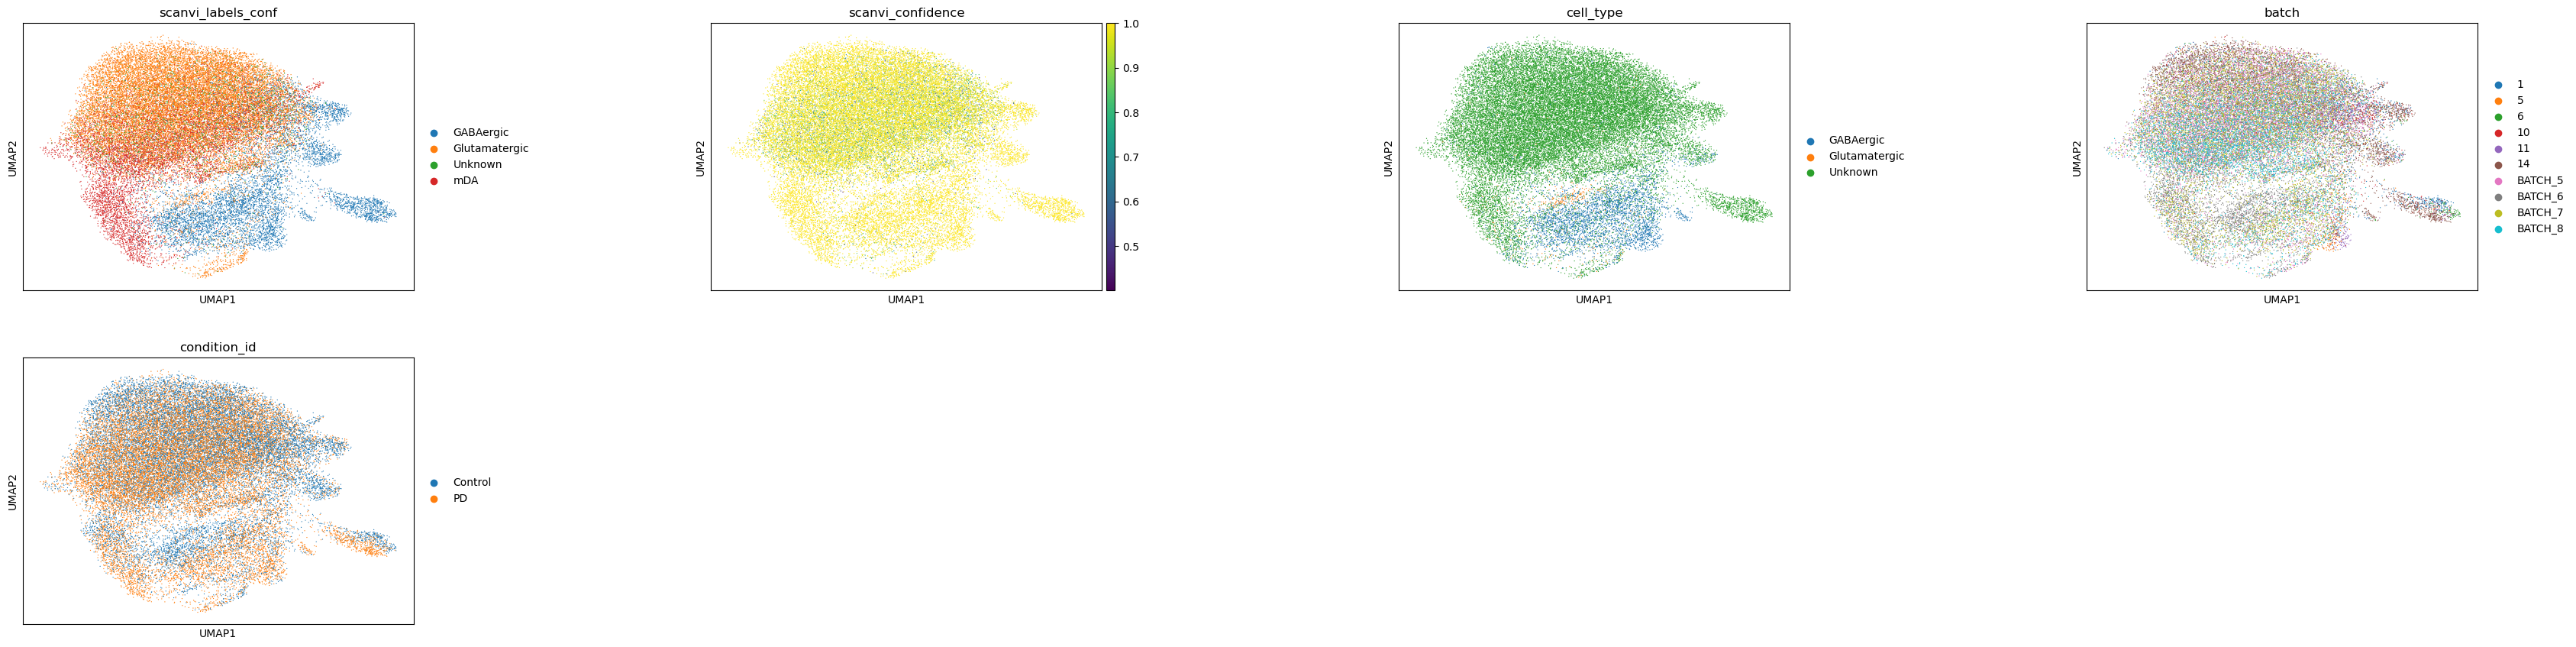

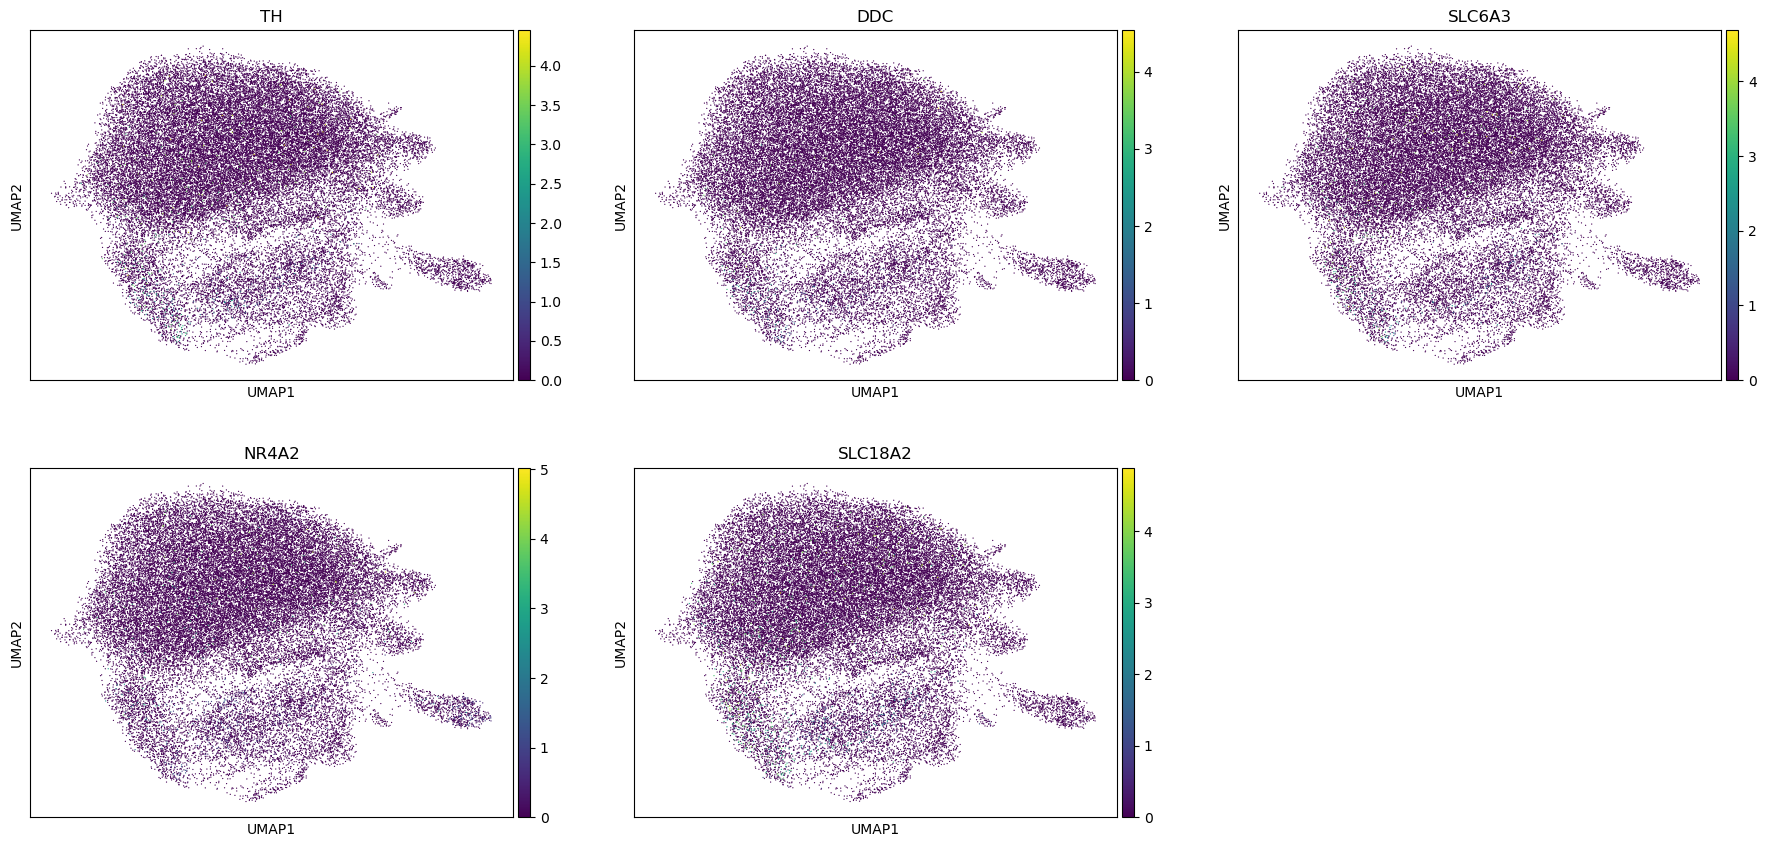

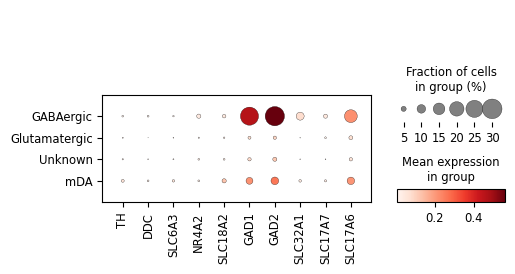

In [71]:
sc.pp.neighbors(adata_hvg, use_rep="X_scVI"); sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg, color=["scanvi_labels_conf","scanvi_confidence", "mmc_class_refined_2", "batch","condition_id"], wspace=0.6)

# Canonical panels
DA_MARKERS = ["TH","DDC","SLC6A3","NR4A2","SLC18A2"]
GABA_MARKERS = ["GAD1","GAD2","SLC32A1"]
GLUT_MARKERS = ["SLC17A7","SLC17A6"]

sc.pl.umap(adata_hvg, color=DA_MARKERS, ncols=3)
sc.pl.dotplot(adata_hvg, var_names=DA_MARKERS+GABA_MARKERS+GLUT_MARKERS, groupby="scanvi_labels_conf")


In [74]:

import scib

# --- CONFIG ---
latent_key = "X_scVI"          # latent representation
label_key  = "scanvi_labels"   # predicted labels
batch_key  = "sample"           # batch/sample column

# --- Run scIB metrics ---
results = {}

# Batch mixing
results["kBET"] = scib.metrics.kBET(
    adata,
    batch_key=batch_key,
    label_key=label_key,
    type_="knn",
    subsample=0.5
)

results["LISI_batch"] = scib.metrics.lisi(
    adata,
    batch_key=batch_key,
    type_="batch",
    n_neighbors=90
)

# Biological conservation
results["ARI"] = scib.metrics.ari(
    adata,
    label_key=label_key,
    cluster_key="leiden_sn_scVI"  # or any clustering you ran
)

results["NMI"] = scib.metrics.nmi(
    adata,
    label_key=label_key,
    cluster_key="leiden_sn_scVI"
)

results["Silhouette"] = scib.metrics.silhouette(
    adata,
    label_key=label_key,
    embed=latent_key
)

# --- Summarize ---
df_results = pd.DataFrame.from_dict(results, orient="index", columns=["score"])
print(df_results)


ModuleNotFoundError: No module named 'scib'